# **Tech_savvy**
## IIT (ISM), Dhanbad
### CrossSell_Upsell Problem Statement

In this project, we have built a hybrid recommender system based on user based collaborative filtering and context aware filtering technique to recommend products to the customer for cross selling and upselling. Unsupervised learning algorithm K-Means Clustering is used to determine the location cluster to which the customer belongs based on their geographical coordinates. The insights gained from this are used to suggest products based on user-user based cosine similarity. This recommender system will thus help to increase its profit margins.

## Importing data and libraries

In order to upload the excel data in the colab file, first the excel file is uploaded in the google drive which is then mounted in this colab file.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
from math import ceil, isnan

import matplotlib.pyplot as plt
import seaborn as sns
from pickle import dump, load

import folium
import geopy

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

Loading the data from google drive.

In [3]:
df = pd.read_excel('/content/gdrive/MyDrive/Maverick Hackathon/Data.xlsx')

## EDA

Here we have carried out exploratory data analysis in order to understand the data which will help us in deciding the route forward.

In [4]:
df.head(10)

,Unnamed: 0,Doc. Date,Material,Order qty,Ship-to nu,PCS delivered,HL delivered,delivery_days,delivery_flag,lead_time_creation_vs_rdd_flag,MACO/HL,Groupement,Postal Code,Street,Sous groupement,M2_Territory_ID,M1_Territory_ID,Dépt,Brand,Subrand,SEGMENTS : Pils / Spécialités / Superspécialités/Bouteille Young adult,Container Type,Container Size,Variétés,Segment LE,Latitude,Longitude,Degre Alc,TTC,Brut + TE,Net + TE - Hors majoration de rompu de palette,DA
0,0,2021-01-11,10946,5.0,29606863,350.0,21.0,7,1,1,150.689825,FRANCE BOISSONS,59160,RUE DU CHEMIN SAINT MARTIN,France BOISSONS,FR01_ON_1000,FR01_ON_1004,59.0,LEFFE,LEFFE BLONDE,Spécialités,PERFECT DRAFT,"6,000 L",Blonde,PREMIUM,50.6455,2.9619,6.6,18.137448,15.582,15.114540,0.0
1,1,2021-01-11,19898,2.0,29606863,140.0,8.4,7,1,1,141.207904,FRANCE BOISSONS,59160,RUE DU CHEMIN SAINT MARTIN,France BOISSONS,FR01_ON_1000,FR01_ON_1004,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.6455,2.9619,5.0,17.396467,14.688,14.497056,0.0
2,2,2021-01-11,80176,4.0,29606863,280.0,16.8,7,1,1,92.872307,FRANCE BOISSONS,59160,RUE DU CHEMIN SAINT MARTIN,France BOISSONS,FR01_ON_1000,FR01_ON_1004,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.6455,2.9619,0.0,12.279859,10.368,10.233216,0.0
3,3,2021-01-11,66989,1.0,29606863,70.0,4.2,7,1,1,195.334035,FRANCE BOISSONS,59160,RUE DU CHEMIN SAINT MARTIN,France BOISSONS,FR01_ON_1000,FR01_ON_1004,59.0,TRIPLE KARMELIET,TRIPLE KARMELIET,Craft,PERFECT DRAFT,"6,000 L",-,SUPER PREMIUM,50.6455,2.9619,8.0,21.996000,18.330,18.330000,0.0
4,4,2021-01-08,11766,70.0,29378784,70.0,4.2,6,1,1,142.902378,INDEPENDANTS,62570,PLACE JEAN JAURES,ALLAN,FR01_ON_2000,FR01_ON_2006,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.6978,2.2423,5.2,17.359200,14.466,14.466000,0.0
5,5,2021-01-08,16550,300.0,29378784,300.0,27.0,6,1,1,25.345586,INDEPENDANTS,62570,PLACE JEAN JAURES,ALLAN,FR01_ON_2000,FR01_ON_2006,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.6978,2.2423,3.8,6.408000,5.340,5.340000,0.0
6,6,2021-01-08,16519,100.0,29378784,100.0,9.0,6,1,1,38.306468,INDEPENDANTS,62570,PLACE JEAN JAURES,ALLAN,FR01_ON_2000,FR01_ON_2006,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.6978,2.2423,4.6,7.747200,6.456,6.456000,0.0
7,7,2021-01-08,66989,70.0,29378784,70.0,4.2,6,1,1,195.334035,INDEPENDANTS,62570,PLACE JEAN JAURES,ALLAN,FR01_ON_2000,FR01_ON_2006,62.0,TRIPLE KARMELIET,TRIPLE KARMELIET,Craft,PERFECT DRAFT,"6,000 L",-,SUPER PREMIUM,50.6978,2.2423,8.0,21.996000,18.330,18.330000,0.0
8,8,2021-01-08,10946,140.0,29378784,140.0,8.4,6,1,1,150.689825,INDEPENDANTS,62570,PLACE JEAN JAURES,ALLAN,FR01_ON_2000,FR01_ON_2006,62.0,LEFFE,LEFFE BLONDE,Spécialités,PERFECT DRAFT,"6,000 L",Blonde,PREMIUM,50.6978,2.2423,6.6,18.698400,15.582,15.582000,0.0
9,9,2021-01-08,29777,70.0,29378784,70.0,4.2,6,1,1,133.095305,INDEPENDANTS,62570,PLACE JEAN JAURES,ALLAN,FR01_ON_2000,FR01_ON_2006,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.6978,2.2423,5.0,12.585600,10.488,10.488000,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73670 entries, 0 to 73669
Data columns (total 32 columns):
 #   Column                                                                  Non-Null Count  Dtype         
---  ------                                                                  --------------  -----         
 0   Unnamed: 0                                                              73670 non-null  int64         
 1   Doc. Date                                                               73670 non-null  datetime64[ns]
 2   Material                                                                73670 non-null  int64         
 3   Order qty                                                               73670 non-null  float64       
 4   Ship-to nu                                                              73670 non-null  int64         
 5   PCS delivered                                                           73666 non-null  float64       
 6   HL delivered          

In [6]:
print('Material wise distribution of dataset:\n')
print(df.groupby('Material').size())

Material wise distribution of dataset:

Material
3337       1171
3338        477
3371          1
3372       2954
3410       2500
           ... 
81409         1
81410        50
81411         1
82315        15
7519873       4
Length: 179, dtype: int64


In [7]:
print('Wholesaler wise distribution of dataset:\n')
print(df.groupby('Ship-to nu').size())

Wholesaler wise distribution of dataset:

Ship-to nu
29378784    316
29378785    870
29378892    134
29378895    232
29378896    319
           ... 
29996996      7
40001857     26
40002273    110
40007881    156
40016990     62
Length: 179, dtype: int64


In [8]:
print('\nStatistics of dataset: ')
df.describe()


Statistics of dataset: 


,Unnamed: 0,Material,Order qty,Ship-to nu,PCS delivered,HL delivered,delivery_days,delivery_flag,lead_time_creation_vs_rdd_flag,MACO/HL,Postal Code,Dépt,Latitude,Longitude,Degre Alc,TTC,Brut + TE,Net + TE - Hors majoration de rompu de palette,DA
count,73670.000000,7.367000e+04,73670.000000,7.367000e+04,73666.000000,73670.000000,73670.000000,73670.000000,73670.000000,68972.000000,73670.000000,72843.000000,69652.000000,69652.000000,70821.000000,70806.000000,70821.000000,70806.000000,70821.000000
mean,36834.500000,3.584769e+04,57.293573,2.949981e+07,90.574689,18.844506,6.764260,0.904412,0.833026,152.099186,53939.645989,54.616875,47.159685,2.502411,5.807900,42.663866,37.012727,35.548765,0.004473
std,21266.841503,6.137106e+04,123.477770,7.424384e+05,170.056738,993.925627,4.044058,0.294028,0.372955,36.736746,25557.863282,23.993058,2.303527,2.620547,1.564772,27.615340,23.535969,23.015250,0.021286
min,0.000000,3.337000e+03,1.000000,2.937878e+07,0.000000,0.000000,-11.000000,0.000000,0.000000,25.345586,2500.000000,2.000000,42.467800,-4.316700,0.000000,6.408000,5.340000,5.340000,0.000000
25%,18417.250000,1.094600e+04,6.000000,2.937963e+07,20.000000,1.800000,6.000000,1.000000,1.000000,133.095305,34070.000000,35.000000,45.416800,0.228700,4.900000,18.093600,15.582000,15.078000,0.000000
50%,36834.500000,2.061400e+04,20.000000,2.937982e+07,48.000000,4.200000,6.000000,1.000000,1.000000,150.689825,59155.000000,59.000000,47.608900,2.448900,5.200000,25.027200,23.712000,20.856000,0.000000
75%,55251.750000,6.270700e+04,70.000000,2.953724e+07,90.000000,12.600000,7.000000,1.000000,1.000000,180.045916,73700.000000,73.000000,48.986900,4.484100,6.600000,62.726496,55.520000,52.272080,0.000000
max,73669.000000,7.519873e+06,7540.000000,4.001699e+07,7540.000000,248820.000000,126.000000,1.000000,1.000000,231.861733,95500.000000,95.000000,50.962300,9.389600,9.000000,110.412000,92.010000,92.010000,0.294000


In [9]:
print('Null values of in respective columns are:\n')
df.isnull().sum()

Null values of in respective columns are:



Unnamed: 0                                                                    0
Doc. Date                                                                     0
Material                                                                      0
Order qty                                                                     0
Ship-to nu                                                                    0
PCS delivered                                                                 4
HL delivered                                                                  0
delivery_days                                                                 0
delivery_flag                                                                 0
lead_time_creation_vs_rdd_flag                                                0
MACO/HL                                                                    4698
Groupement                                                                    0
Postal Code                             

## Data Pre-Processing and Data Visualization

As we can see that multiple fields of latitude, longitude and MACO/HL which are NULL, we will have to remove the fields which have NULL values in these fields. Also as the dataset contains nearly 73000 data points, removing some of them will not affect our results significantly.

In [10]:
df.dropna(subset = ['MACO/HL ', 'Latitude', 'Longitude'], inplace = True)
df.reset_index(drop = True, inplace = True)
df.isnull().sum()

Unnamed: 0                                                                    0
Doc. Date                                                                     0
Material                                                                      0
Order qty                                                                     0
Ship-to nu                                                                    0
PCS delivered                                                                 1
HL delivered                                                                  0
delivery_days                                                                 0
delivery_flag                                                                 0
lead_time_creation_vs_rdd_flag                                                0
MACO/HL                                                                       0
Groupement                                                                    0
Postal Code                             

Here we are adding an extra column of total product sold in HL corresponding to each row, in our dataframe.

In [11]:
tot = []
print(df.shape[0])

for i in range(df.shape[0]):
  tot.append(int(ceil(df._get_value(i, 'Order qty')*df._get_value(i, 'HL delivered'))))

df.insert(7, "Total_HL", tot)

65222


In order to segregate data on the basis of geographical coordinates of the wholesaler, we define two dictionaries loc_wise_sales which stores the total sales of product in HL and loc_wise_maco which stores the MACO/HL, both corresponding to a pair of latitude and longitude values.

In [12]:
loc_wise_sales = {}
loc_wise_maco = {}
loc_wise_user_id = {}
wholesaler_loc = {}

for i in range(df.shape[0]):
  if(isnan(df._get_value(i, "Latitude")) or isnan(df._get_value(i, "Longitude")) or isnan(df._get_value(i, "MACO/HL "))):
    continue
  temp = str(df._get_value(i, "Latitude")) + ", " + str(df._get_value(i, "Longitude"))
  if(temp in loc_wise_sales.keys()):
    loc_wise_sales[temp]+=df._get_value(i, "Total_HL")
  else:
    loc_wise_sales[temp]=df._get_value(i, "Total_HL")
  if(temp in loc_wise_maco.keys()):
    loc_wise_maco[temp]+=df._get_value(i, "MACO/HL ")
  else:
    loc_wise_maco[temp]=df._get_value(i, "MACO/HL ")
  if(temp not in loc_wise_user_id.keys()):
    loc_wise_user_id[temp]=str(df._get_value(i, "Ship-to nu"))
  wholesaler_loc[str(df._get_value(i, "Ship-to nu"))] = temp

dump(wholesaler_loc, open("wholesaler_loc.pkl", "wb"))

Now, a dataframe consisting of data segregated based on geographical coordinates has been created.

In [13]:
modified_data = []
for key, value in loc_wise_sales.items():
  temp = key.split(", ")
  values_list = {}
  values_list["Latitude"] = float(temp[0])
  values_list["Longitude"] = float(temp[1])
  values_list["Total_HL"] = value
  values_list["MACO"] = loc_wise_maco[key]*value
  values_list["ID"] = loc_wise_user_id[key]

  modified_data.append(values_list)

data_frame = pd.DataFrame(modified_data)
print(data_frame.shape)
data_frame.head(20)

(164, 5)


,Latitude,Longitude,Total_HL,MACO,ID
0,50.6455,2.9619,147116,1.595025e+10,29606863
1,50.6978,2.2423,112089,4.841419e+09,29378784
2,47.5382,6.4026,1799301,2.076979e+11,29379853
3,43.7330,6.1765,1234120,2.560319e+11,29379855
4,46.8354,-0.7778,530884,6.574317e+10,29379861
5,50.7263,2.6309,356985,2.102836e+10,29379635
6,47.7954,6.4907,174602,2.250946e+10,29379829
7,50.6177,2.3964,4528738,5.745806e+11,29378785
8,49.8270,4.2107,3596157,3.354982e+11,29635311
9,43.1228,6.0075,732223,6.387637e+10,29378992


Testing whether map is being displayed or not and determining an accurate position for base location of the map such that all the data points are clearly visible on the map.

In [14]:
map_ = folium.Map(location = (47, 3), tiles = "cartodbpositron", zoom_start = 5)
map_

In order to visualize the data and the sales history corresponding to geographical position of the wholesaler, a map is plotted as can be seen below. The total sales done in HL was scaled down to a range between 2 and 20 and the total MACO points were scaled down to a range between 0 to 100. The size of circle at each location is a measure of the total sales made in HL. On clicking a particular location, a popup appears which gives information about total MACO points at that location on a scale of 0 to 100.

In [15]:
x, y = "Latitude", "Longitude"
#color = "Brand"
size = "Total_HL"
popup = "MACO"
data = data_frame.copy()

"""
colors = ["red", "orange", "yellow", "blue", "green", "violet", "maroon", "black", "indigo", "white"]
elements = list(df[color].unique())
print(elements)
data["color"] = data[color].apply(lambda x: colors[elements.index(x)])
"""

scaler = preprocessing.MinMaxScaler(feature_range = (2, 20))
data["size"] = scaler.fit_transform(data[size].values.reshape(-1,1)).reshape(-1)

scaler = preprocessing.MinMaxScaler(feature_range = (0, 100))
data["popup"] = scaler.fit_transform(data[popup].values.reshape(-1,1)).reshape(-1)

_map = folium.Map(location = (47, 3), tiles = "cartodbpositron", zoom_start = 5)

data.apply(lambda row: folium.CircleMarker(location = [row[x], row[y]], popup = str("{:.2f}".format(row["popup"])), fill = True, 
                                          radius = row["size"]).add_to(_map), axis = 1)
_map

## Recommender System

In order to divide the wholesalers into clusters corresponding to their locations, unsupervised learning is used. K-Means Clustering divides the wholesalers into clusters of locations. In order to determine the appropriate number of clusters we make use of elbow method.

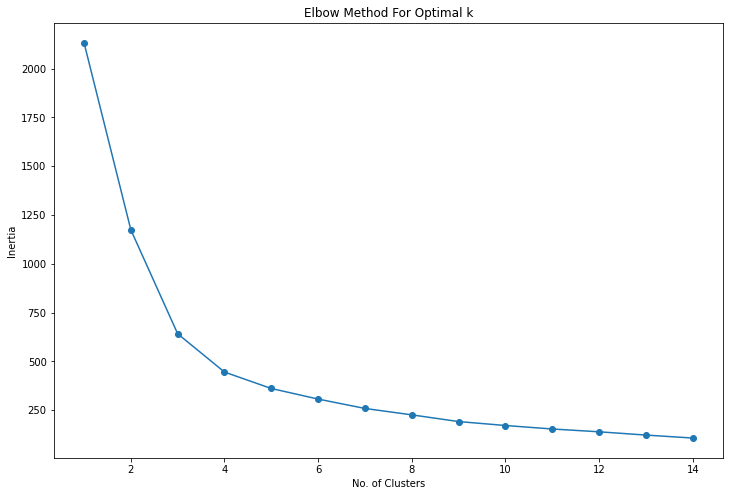

In [16]:
coordinates = data_frame[['Longitude','Latitude']]

inertia = []
clusters = range(1,15)
for k in clusters:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coordinates)
    inertia.append(kmeansModel.inertia_)

fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(clusters, inertia, marker='o')
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.savefig('elbow.png')
plt.show()

Silhouette score is a metric used to calculate the goodness of a clustering technique and helps us to decide the number of clusters to be formulated from the data.

In [17]:
sil = []
kmax = 15

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coordinates)
  labels = kmeans.labels_
  sil.append(silhouette_score(coordinates, labels, metric = 'euclidean'))

sil

[0.42564951631910813,
 0.4921705749469331,
 0.49586928637596855,
 0.4545160163645236,
 0.40785117577485214,
 0.3985869937579832,
 0.42189249770182286,
 0.41280154599633306,
 0.4211517047134766,
 0.42715197564617324,
 0.42091221145732655,
 0.42843307011592047,
 0.44186929065197894,
 0.44718304591973573]

From the elbow method and silhouette score, we can conclude that ideal number of clusters is a value approximately between 6 to 10. In order to decide the final number of clusters, we plot map of clustered locations corresponding to 6, 8 and 12 as number of clusters.

   Latitude  Longitude  Total_HL          MACO        ID  Cluster
0   50.6455     2.9619    147116  1.595025e+10  29606863        2
1   50.6978     2.2423    112089  4.841419e+09  29378784        2
2   47.5382     6.4026   1799301  2.076979e+11  29379853        9
3   43.7330     6.1765   1234120  2.560319e+11  29379855        6
4   46.8354    -0.7778    530884  6.574317e+10  29379861        8
5   50.7263     2.6309    356985  2.102836e+10  29379635        2
6   47.7954     6.4907    174602  2.250946e+10  29379829        9
7   50.6177     2.3964   4528738  5.745806e+11  29378785        2
8   49.8270     4.2107   3596157  3.354982e+11  29635311        7
9   43.1228     6.0075    732223  6.387637e+10  29378992        6


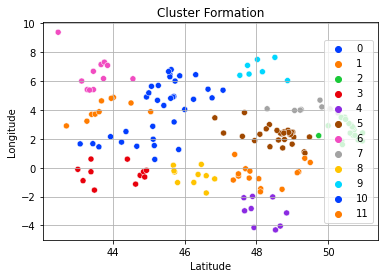

In [18]:
model = KMeans(n_clusters = 12) #init = k-Means++ (by default)
data_frame["Cluster"] = model.fit_predict(coordinates)
print(data_frame.head(10))

fig, ax = plt.subplots()

plt.grid()
plot = sns.scatterplot(x = "Latitude", y = "Longitude", data = data_frame, 
                palette = sns.color_palette("bright", 12), hue = 'Cluster',
                legend = "brief", ax = ax)
plot.set_title("Cluster Formation")
plot.legend(loc = 'right')

   Latitude  Longitude  Total_HL          MACO        ID  Cluster
0   50.6455     2.9619    147116  1.595025e+10  29606863        1
1   50.6978     2.2423    112089  4.841419e+09  29378784        1
2   47.5382     6.4026   1799301  2.076979e+11  29379853        6
3   43.7330     6.1765   1234120  2.560319e+11  29379855        7
4   46.8354    -0.7778    530884  6.574317e+10  29379861        3
5   50.7263     2.6309    356985  2.102836e+10  29379635        1
6   47.7954     6.4907    174602  2.250946e+10  29379829        6
7   50.6177     2.3964   4528738  5.745806e+11  29378785        1
8   49.8270     4.2107   3596157  3.354982e+11  29635311        1
9   43.1228     6.0075    732223  6.387637e+10  29378992        7


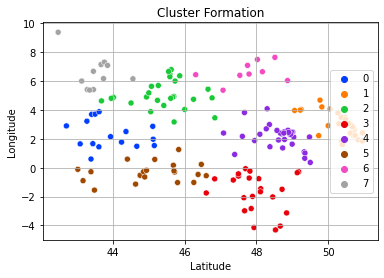

In [19]:
model = KMeans(n_clusters = 8) #init = k-Means++ (by default)
data_frame["Cluster"] = model.fit_predict(coordinates)
print(data_frame.head(10))

fig, ax = plt.subplots()

plt.grid()
plot = sns.scatterplot(x = "Latitude", y = "Longitude", data = data_frame, 
                palette = sns.color_palette("bright", 8), hue = 'Cluster',
                legend = "brief", ax = ax)
plot.set_title("Cluster Formation")
plot.legend(loc = 'right')

   Latitude  Longitude  Total_HL          MACO        ID  Cluster
0   50.6455     2.9619    147116  1.595025e+10  29606863        5
1   50.6978     2.2423    112089  4.841419e+09  29378784        5
2   47.5382     6.4026   1799301  2.076979e+11  29379853        4
3   43.7330     6.1765   1234120  2.560319e+11  29379855        2
4   46.8354    -0.7778    530884  6.574317e+10  29379861        0
5   50.7263     2.6309    356985  2.102836e+10  29379635        5
6   47.7954     6.4907    174602  2.250946e+10  29379829        4
7   50.6177     2.3964   4528738  5.745806e+11  29378785        5
8   49.8270     4.2107   3596157  3.354982e+11  29635311        5
9   43.1228     6.0075    732223  6.387637e+10  29378992        2


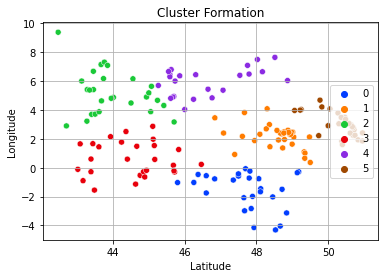

In [20]:
model = KMeans(n_clusters = 6, random_state = 0) #init = k-Means++ (by default)
data_frame["Cluster"] = model.fit_predict(coordinates)
print(data_frame.head(10))
data_frame.to_csv('data_frame.csv')

fig, ax = plt.subplots()

plt.grid()
plot = sns.scatterplot(x = "Latitude", y = "Longitude", data = data_frame, 
                palette = sns.color_palette("bright", 6), hue = 'Cluster',
                legend = "brief", ax = ax)
plot.set_title("Cluster Formation")
plot.legend(loc = 'right')

In [21]:
#Final number of clusters = 6

Finally, as observed from the plots above, 6 seems to be the ideal value for number of clusters in our K-Means Clustering model for the data present uptill now.

In [22]:
df.keys()

Index(['Unnamed: 0', 'Doc. Date', 'Material', 'Order qty', 'Ship-to nu',
       'PCS delivered', 'HL delivered', 'Total_HL', 'delivery_days',
       'delivery_flag', 'lead_time_creation_vs_rdd_flag', 'MACO/HL ',
       'Groupement', 'Postal Code', 'Street', 'Sous groupement',
       'M2_Territory_ID', 'M1_Territory_ID', 'Dépt', 'Brand', 'Subrand',
       'SEGMENTS : Pils / Spécialités / Superspécialités/Bouteille Young adult',
       'Container Type', 'Container Size', 'Variétés', 'Segment LE',
       'Latitude', 'Longitude', 'Degre Alc', 'TTC', 'Brut + TE',
       'Net + TE - Hors majoration de rompu de palette', 'DA'],
      dtype='object')

Now, in order to understand user-user similarity, we segregate the data corresponding the the wholesaler ID's provided.

In [23]:
material_index = {}
index_to_material = {}
user_purchase_history = {}
cnt = 0
material = list(df.Material.unique())

for i in material:
  material_index[i] = cnt
  index_to_material[cnt] = i
  cnt += 1

for i in range(df.shape[0]):
  user_id = df._get_value(i, "Ship-to nu")
  material_id = df._get_value(i, "Material")
  total_hl = df._get_value(i, "Total_HL")
  if(user_id not in user_purchase_history.keys()): 
    temp = []
    for j in range(len(material_index)):
      temp.append(0)
    user_purchase_history[user_id] = temp
  user_purchase_history[user_id][material_index[material_id]] += total_hl

purchase_df = pd.DataFrame.from_dict(user_purchase_history, orient = 'index', columns = material)
purchase_df.head(20)

dump(index_to_material, open("index_to_material.pkl", "wb"))
purchase_df.to_csv("purchase_df.csv")

Here, we calculate mean of the amount of purchase done by each wholesaler in HL and add it to the dataframe.

In [24]:
purchase_df['Mean'] = purchase_df.mean(axis = 1)
purchase_df.head(5)

,10946,19898,80176,66989,11766,16550,16519,29777,48859,3450,63480,70601,10947,33335,20614,63481,59874,71316,3530,18690,61629,64665,17028,53566,48537,60036,30822,3338,3337,77589,59873,10611,63445,78356,59848,76623,54632,63482,72328,59847,71317,9974,3372,3410,78355,11574,10957,70572,63311,10965,6013,15985,5983,66738,69265,65660,60387,59286,74582,66839,77313,57005,63627,54639,37961,80417,3411,54232,72434,20527,70579,Mean
29606863,7418,1004,728,1178,0,4719,2735,4726,698,0,0,0,95,167,504,0,811,0,0,35,0,0,72,0,510,0,0,368,2397,48,45,132,0,0,27294,48,0,0,0,124,199,292,34277,26193,0,10417,125,0,180,5033,880,0,9273,0,0,0,0,0,0,88,1244,2092,16,12,344,0,0,422,0,0,173,2072.056338
29378784,11476,3420,1176,1662,1716,62371,6750,2651,720,18,8,48,84,50,96,20,2367,102,66,8,174,0,36,54,72,8,64,8,7129,0,56,0,0,120,332,0,160,18,24,0,0,100,2993,4384,0,460,120,48,0,0,2,0,223,80,0,0,0,0,0,1,0,594,0,0,0,0,0,0,0,0,20,1578.718310
29379853,357564,207420,0,32722,192386,0,0,0,317,2357,43363,15907,265083,50007,62388,30888,56,34141,4430,3223,25056,30076,4126,7066,8830,0,48,16,587,48,48,2661,115,60283,22,60,2080,3553,189042,29,159,1292,0,0,320,20090,572,139650,0,660,35,0,0,244,0,0,0,0,0,0,98,6,4,0,0,0,0,0,0,0,173,25342.267606
29379855,278712,43693,36,27658,156645,0,0,6,966,216,6083,15876,14449,2724,5591,4425,7438,11760,8232,3036,13818,13524,4506,6468,10185,2724,16,160,8862,9889,2293,1326,69,6511,0,4948,3124,1493,11551,0,9329,4048,261043,11102,0,178307,5436,8232,0,571,30618,0,0,2804,3746,5760,0,11,0,0,11500,432,220,0,0,720,0,11208,0,0,20,17381.971831
29379861,20993,8546,78,8796,3591,207,0,1191,0,0,0,564,9610,635,10027,365,336,2571,504,5971,10837,0,840,0,1550,0,152,24,980,58,112,1176,0,0,0,840,0,0,0,0,20971,19028,100405,70336,0,79655,794,29400,44,6992,92282,179,2705,144,360,3461,217,0,0,26,65,1182,746,0,120,630,0,431,0,0,10157,7477.239437


Each value in a row has been subtracted by their corresponding mean values, which will be used to determine the cosine similarity between the wholesalers.

In [25]:
coorelation_df = purchase_df.copy()
index = list(coorelation_df.index)

for i in range(purchase_df.shape[0]):
  for j in material:
    if(coorelation_df._get_value(index[i], j) != 0):
      coorelation_df.iloc[i, coorelation_df.columns.get_loc(j)] -= coorelation_df._get_value(index[i], "Mean")

coorelation_df.head(10)
coorelation_df.to_csv("coorelation_df.csv")

Here, we calculate the cosine similarity between the wholesalers.

In [26]:
sim = cosine_similarity(coorelation_df)
sim

array([[ 1.00000000e+00,  1.02304838e-01,  3.85017624e-02, ...,
        -2.20242139e-03,  8.91960409e-02, -3.95595580e-02],
       [ 1.02304838e-01,  1.00000000e+00,  9.46478171e-02, ...,
        -9.92991164e-04,  6.98885223e-04,  3.71493272e-04],
       [ 3.85017624e-02,  9.46478171e-02,  1.00000000e+00, ...,
        -4.83052734e-02, -1.01448820e-01, -4.69795620e-02],
       ...,
       [-2.20242139e-03, -9.92991164e-04, -4.83052734e-02, ...,
         1.00000000e+00,  7.74724992e-04,  3.61525349e-03],
       [ 8.91960409e-02,  6.98885223e-04, -1.01448820e-01, ...,
         7.74724992e-04,  1.00000000e+00,  5.02941358e-04],
       [-3.95595580e-02,  3.71493272e-04, -4.69795620e-02, ...,
         3.61525349e-03,  5.02941358e-04,  1.00000000e+00]])

Creating a dataframe which contains information about cosine similarity index of each wholesaler with every other wholesaler.

In [27]:
sim_df = pd.DataFrame(sim, columns = coorelation_df.index.values, index = coorelation_df.index.values).reset_index()
sim_df.to_csv("sim_df.csv")
sim_df.head(5)

,index,29606863,29378784,29379853,29379855,29379861,29379635,29379829,29378785,29635311,29378992,29379621,29379639,29595514,29379626,29379862,40007881,29799562,29379695,29379067,29379676,29379116,29379610,29379830,29379283,29379684,29379651,29379820,29379646,29379556,29563817,29379815,29379625,40016990,29379641,29379865,29379622,29379566,29563820,29379692,...,29379858,29563809,29379866,29379845,29379916,29379846,29378892,29379681,29379002,29379818,29379840,29378896,29727962,29379834,40002273,29379708,29379701,29996996,29379101,29379089,29379833,29379686,29801553,29379015,29379664,29996995,29379915,29833190,29379642,29379824,29793472,29974413,29446255,29804035,29563563,29750335,29986364,40001857,29983887,29643421
0,29606863,1.000000,0.102305,0.038502,0.502652,0.620218,0.533435,0.214170,0.081010,0.139333,0.603886,0.089002,0.486831,0.418743,0.194553,0.470338,0.292952,0.414444,0.157621,0.223977,0.837234,0.391382,0.291752,0.175948,0.313079,0.253148,0.332579,0.189617,0.870483,0.589367,0.370207,0.561503,0.192095,0.080456,0.870801,0.272648,0.491476,0.264218,0.488250,0.396289,...,0.444129,0.533013,0.480513,0.400230,0.836157,0.073645,0.648330,0.568276,0.343060,0.489944,0.511782,0.462572,0.672925,0.384295,0.480733,0.476923,0.159601,0.617756,0.224393,0.165257,0.277309,0.156264,0.471057,0.702687,0.605273,0.616385,0.855130,-0.042427,0.867296,0.184410,0.409901,0.083217,0.040175,0.099948,0.068949,0.089519,0.051382,-0.002202,0.089196,-0.039560
1,29378784,0.102305,1.000000,0.094648,0.121270,-0.015611,0.357012,0.105509,0.157668,0.161028,0.068689,-0.002218,0.046960,0.139466,0.146253,0.061239,0.143189,0.071205,0.117921,0.065200,0.022592,0.084809,0.163679,0.132578,0.017324,0.030020,0.145018,0.131092,0.017473,0.152431,-0.003909,0.056326,0.132796,0.131500,0.055741,0.105396,0.131860,-0.004209,0.003228,0.162271,...,0.003039,0.086732,0.025575,0.021381,0.175529,-0.023174,0.074815,-0.000608,-0.000596,0.041721,0.042568,0.040726,0.178152,-0.016911,0.017405,0.007366,0.110672,0.020588,0.153260,-0.019431,-0.005027,-0.019828,0.098596,0.027341,0.000823,0.013899,0.017977,0.000400,0.036182,-0.000104,-0.024006,0.121449,0.130882,0.146674,0.123240,0.157612,0.124869,-0.000993,0.000699,0.000371
2,29379853,0.038502,0.094648,1.000000,0.515184,0.074125,0.481821,0.646900,0.697570,0.461268,0.099119,0.009156,-0.071926,0.580113,0.716581,0.385839,0.663377,0.360258,0.675151,0.596933,-0.051180,0.557258,0.702729,0.670213,-0.000057,0.135541,0.673429,0.650882,-0.018498,0.560813,-0.029991,0.237870,0.585036,0.491680,-0.046255,0.566070,0.479285,0.027437,-0.027625,0.575111,...,-0.020505,0.292787,-0.024631,0.028849,-0.050848,-0.046391,-0.019292,-0.011909,-0.022591,-0.001551,-0.012878,0.043658,0.171135,-0.068073,-0.028664,0.050978,0.487448,-0.008927,0.675273,-0.019343,-0.084935,-0.022661,0.211728,-0.016503,-0.040641,-0.002309,-0.024881,-0.049947,-0.014782,-0.035340,-0.029386,0.721232,0.566780,0.641774,0.784591,0.675674,0.706778,-0.048305,-0.101449,-0.046980
3,29379855,0.502652,0.121270,0.515184,1.000000,0.560703,0.812595,0.804033,0.644477,0.543555,0.522436,0.119983,0.209498,0.720341,0.710286,0.768232,0.785873,0.613159,0.745004,0.413488,0.583691,0.562796,0.733829,0.774884,0.479561,0.495456,0.735969,0.696597,0.602816,0.885049,0.548881,0.517549,0.704008,0.508358,0.344839,0.756581,0.889133,0.373483,0.572238,0.753555,...,0.555917,0.491281,0.175831,0.361567,0.128067,0.167527,0.169307,0.655918,0.374568,0.008237,0.005620,0.183036,0.702941,0.493335,0.277313,0.670272,0.489944,0.482376,0.582980,0.370926,0.313700,0.366770,0.203682,0.590157,0.655777,0.654761,0.450580,-0.018978,0.414069,0.324520,0.321224,0.594694,0.540363,0.571564,0.562622,0.626260,0.540658,-0.037339,-0.025898,-0.028579
4,29379861,0.620218,-0.015611,0.074125,0.560703,1.000000,0.449230,0.338522,0.088605,0.122005,0.640628,0.591114,0.333550,0.391335,0.306183,0.612885,0.321156,0.586820,0.253597,0.016721,0.774933,0.230472,0.316971,0.282244,0.557329,0.491934,0.284738,0.324468,0.716286,0.560545,0.804233,0.683137,0.278531,0.076250,0.667320,0.

## Prediction

Creating a dictionary which stores list of all the wholesalers which belong to a particular cluster.

In [28]:
cluster_members = {}

for i in range(data_frame.shape[0]):
  temp = data_frame._get_value(i, "Cluster")
  user_id = df._get_value(i, "Ship-to nu")
  if(temp not in cluster_members.keys()):
    cluster_members[temp] = []
  cluster_members[temp].append(user_id)

#As we get duplicate values of wholesalers in the dictionary we need to make them unique
for i in cluster_members.keys():
  cluster_members[i] = np.unique(cluster_members[i])

dump(cluster_members, open("cluster_members.pkl", "wb"))

Defining a function which returns a list of all the products bought by a particular wholesaler.

In [29]:
def product_list(user_id):
  product_bought = []
  for i in range(purchase_df.shape[1]-1):
    #print(index_to_material[i])
    val = purchase_df._get_value(user_id, index_to_material[i])
    if(val != 0):
      product_bought.append(index_to_material[i])
  return product_bought

Creating a dictionary which stores the MACO/HL corresponding to each material id.

In [30]:
maco_per_hl = {}

for i in range(df.shape[0]):
  id = df._get_value(i, "Material")
  maco_per_hl[id] = df._get_value(i, "MACO/HL ")

dump(maco_per_hl, open("maco_per_hl.pkl", "wb"))

Defining a function to display the all the wholesalers that belong to the cluster in which the given user is present. This will be used to narrate a story to the user that explains that the location is one of the reasons why he is being recommended such products. 

In [31]:
def story_display(cluster_pred):
  x, y = "Latitude", "Longitude"
  size = "Total_HL"
  popup = "MACO"
  data = data_frame.copy()
  
  scaler = preprocessing.MinMaxScaler(feature_range = (2, 20))
  data["size"] = scaler.fit_transform(data[size].values.reshape(-1,1)).reshape(-1)

  scaler = preprocessing.MinMaxScaler(feature_range = (0, 100))
  data["popup"] = scaler.fit_transform(data[popup].values.reshape(-1,1)).reshape(-1)

  map = folium.Map(location = (47, 3), tiles = "cartodbpositron", zoom_start = 5)

  for i, row in data.iterrows():
    if(row["Cluster"] == cluster_pred):
      #print(row['Cluster'], row[x], row[y])
      folium.CircleMarker(location = [row[x], row[y]], popup = str("{:.2f}".format(row["popup"])), 
                          fill = True, radius = row["size"]).add_to(map)
                          
  return map

Defining a predict function which takes in the user id as a parameter and returns a list of products to be recommended to the user.

In [32]:
def predict(user_id):
  temp = wholesaler_loc[str(user_id)].split(", ")
  #x = float(temp[0])
  #y = float(temp[1])
  print(len(data_frame.index[data_frame['ID']==str(user_id)].to_list()))
  cluster_pred = data_frame._get_value(data_frame.index[data_frame['ID']==str(user_id)].to_list()[0], "Cluster")     #model.predict([[x, y]])
  map_ = story_display(cluster_pred)
  possible_users = []
  for i in cluster_members[int(cluster_pred)]:
    if(i == user_id):
      continue
    similarity = sim_df.iloc[sim_df.columns.get_loc(user_id)-1, sim_df.columns.get_loc(i)]
    possible_users.append([similarity, i])

  possible_users = sorted(possible_users, reverse = True)
  
  product_bought = product_list(user_id)
  possible_recomm = []
  
  for i in range(5):
    temp = product_list(possible_users[i][1])
    for j in temp:
      if(j not in set(product_bought) and j not in set(item[1] for item in possible_recomm)):
        possible_recomm.append([maco_per_hl[j], j])

  possible_recomm = sorted(possible_recomm, reverse = True)
  #print(possible_recomm)

  recommend = []

  for i in range(15):
    recommend.append(possible_recomm[i][1])
  
  return [recommend, map_]

recommendations, map_ = predict(29606863)
print(recommendations)
map_

1
[53566, 64665, 3530, 3450, 72328, 54632, 70601, 60387, 74582, 65660, 30822, 3411, 78355, 69265, 11766]


The above map depicts the story behind the proposed recommendations. There lies a huge possibility that a customer's taste highly depends on the particular locality one lives in. So, recommending products based on the purchase done by other customers in that region has a lot of potential to increase the gain margins. A message will be displayed on the customer's screen that, "You belong to the following locality and our customers in this locality prefer the following products. You can have a look at them and feel free to place a order."

## Conclusion

This the above model can be used to recommend products to the wholesaler in order to increase the gain margins of the company.

## Future Prospects

In order to work on this project further, we will require additional data.

In order to take a new product into account for recommendations, we will require features of the products, like how old is the alcoholic beverage or what are the key constituents of the beverage etc. This will help us in comparing the similarity of the products user has bought with that of a new product and based on that we can make a decision whether to recommend a new product to a particular wholesaler or not.

Apart from this, the data of ratings given to a product by the customer will help us prioritze products which was liked by more customers and has a higher chance of being bought by other customers also beacuse of its popularity.

Yet, another feature that we can implement is a bot. This bot will ask specific questions to the customer which will help us identify the taste of the user and on this basis products can be recommended to the user. But this will also require additional data of features of the products as explained above.